In [42]:
from typing import Callable
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score
from time import time_ns
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
plt.rcParams["figure.figsize"] = (20,10)
random_state = 244827
n_samples = 2427

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [3]:
def mse_cost(predicted, actual):
    return np.mean((predicted - actual) ** 2)


def logistic_cost(predicted, actual):
    return -np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))

In [4]:
class MyLogisticRegression:
    def __init__(self, learning_rate: float = 0.05, max_iterations: int = 100, min_cost_diff: float = 0.001,
                 cost_function: Callable = mse_cost):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.min_cost_diff = min_cost_diff
        self.coef_ = None
        self.intercept_ = None
        self.cost_function = cost_function
        self.costs = []

    def fit(self, X, Y):
        if self.coef_ is None:
            self.coef_ = np.random.normal(loc=1, scale=0.15, size=(1, X.shape[1]))
            self.intercept_ = np.random.normal(loc=1, scale=0.15, size=1)

        Y = Y.reshape(-1, 1)
        n = X.shape[0]
        for i in range(self.max_iterations):
            preds = sigmoid(X.dot(self.coef_.T) + self.intercept_)
            cost = self.cost_function(preds, Y)

            dW = 1/n * np.dot((preds - Y).T, X)
            dB = 1/n * np.sum(preds - Y)

            self.coef_ = self.coef_ - self.learning_rate * dW
            self.intercept_ = self.intercept_ - self.learning_rate * dB

            self.costs.append(cost)

            if len(self.costs) >= 2 and self.costs[-2] - self.costs[-1] < self.min_cost_diff:
                break

        return self

    def decision_function(self, X):
        return sigmoid(X.dot(self.coef_.T) + self.intercept_)

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0.5, 1, 0)

In [5]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v

In [14]:
def compare_models(data: PUMData):
    my_start = time_ns()
    for _ in range(100):
        my_model = MyLogisticRegression(learning_rate=0.5, max_iterations=10000, min_cost_diff=1e-4)
        my_model.fit(data.x_train, data.y_train)
    my_time = time_ns() - my_start

    my_model = MyLogisticRegression(learning_rate=0.5, max_iterations=10000, min_cost_diff=1e-4)
    sk_model = LogisticRegression(max_iter=100, random_state=random_state)

    sk_start = time_ns()
    for _ in range(100):
        sk_model = LogisticRegression(max_iter=100, random_state=random_state)
        sk_model.fit(data.x_train, data.y_train)
    sk_time = time_ns() - sk_start

    print(f'Implementacja wlasna \tuczyla sie przez {my_time/100} ns')
    print(f'Model sklearn \t\t\t uczyl sie przez {sk_time/100} ns')

    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z_an = my_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    Z_sk = sk_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model LogisticRegression']):
        axarr[idx].contourf(xx, yy, Z, alpha=0.4)
        axarr[idx].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    plt.show()

    y_an_predicted = my_model.predict(data.x_test)
    y_sk_predicted = sk_model.predict(data.x_test)

    cm_sk = confusion_matrix(data.y_test, y_sk_predicted)
    cm_an = confusion_matrix(data.y_test, y_an_predicted)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model LogisticRegression']
    ):
        sns.heatmap(cm, annot=True, fmt="d", ax=axarr[idx], cmap="Blues")
        axarr[idx].set_title(title)

    plt.show()

    my_function = my_model.decision_function(data.x_test)
    sk_function = sk_model.decision_function(data.x_test)

    fpr, tpr, thresholds = roc_curve(data.y_test, my_function)
    plt.plot(fpr, tpr, label=f'my model, AUC={roc_auc_score(data.y_test, my_function):.3f}')
    fpr, tpr, thresholds = roc_curve(data.y_test, sk_function)
    plt.plot(fpr, tpr, label=f'sklearn model, AUC={roc_auc_score(data.y_test, sk_function):.3f}')
    plt.legend()
    plt.show()

Implementacja wlasna 	uczyla sie przez 20348800 ns
Model sklearn 			 uczyl sie przez 2977000 ns


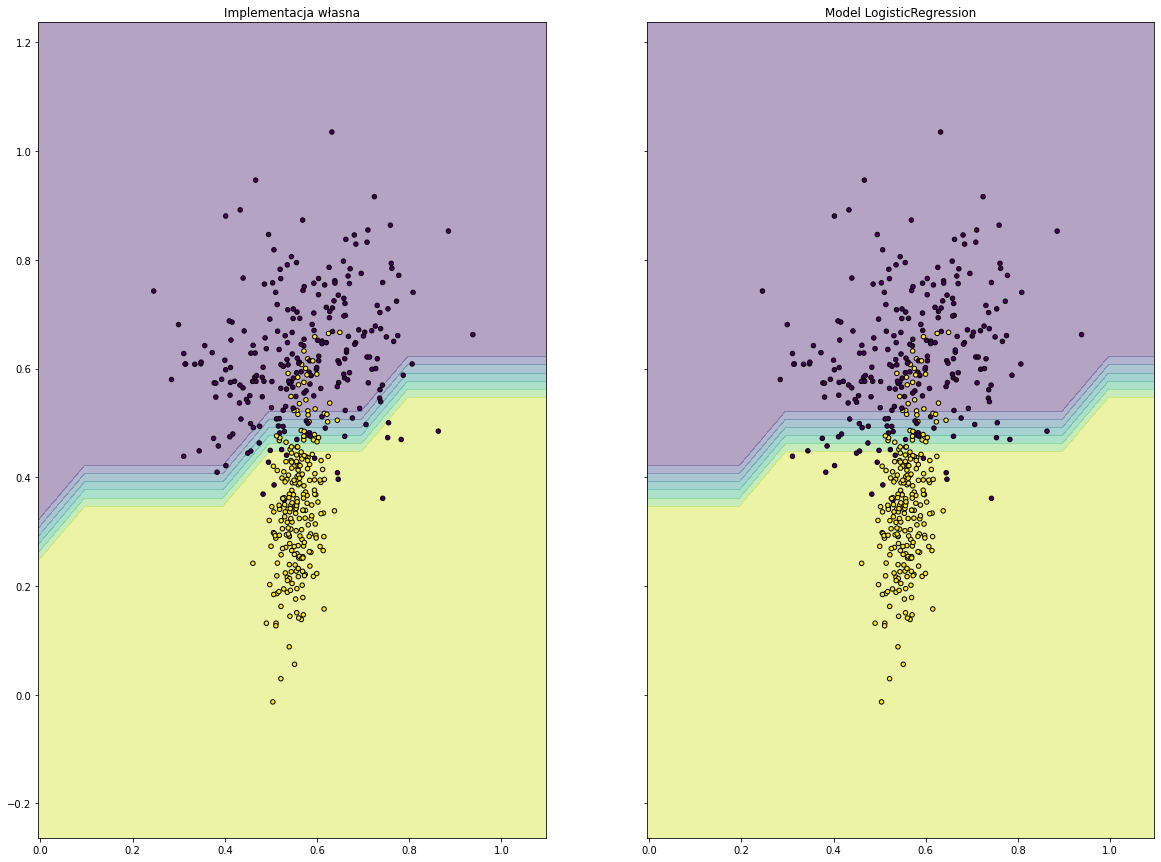

Implementacja wlasna 	wykonała predykcje w 0 ns
Model sklearn 			 wykonał predykcje w 0 ns


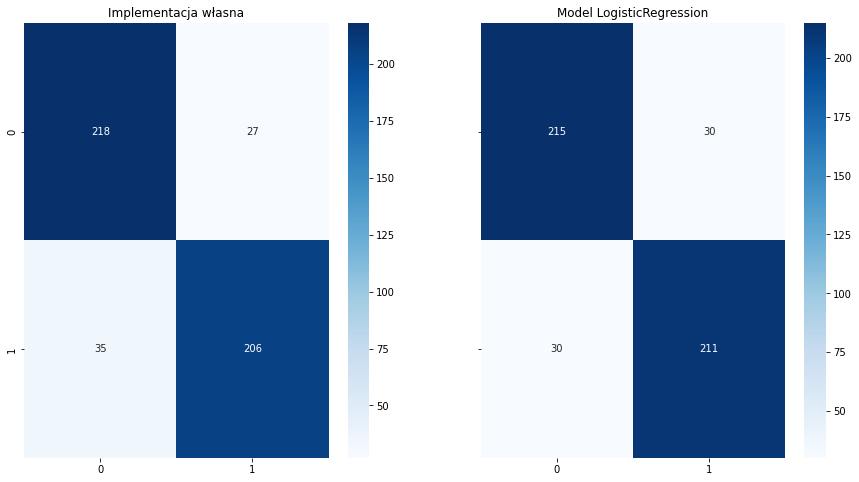

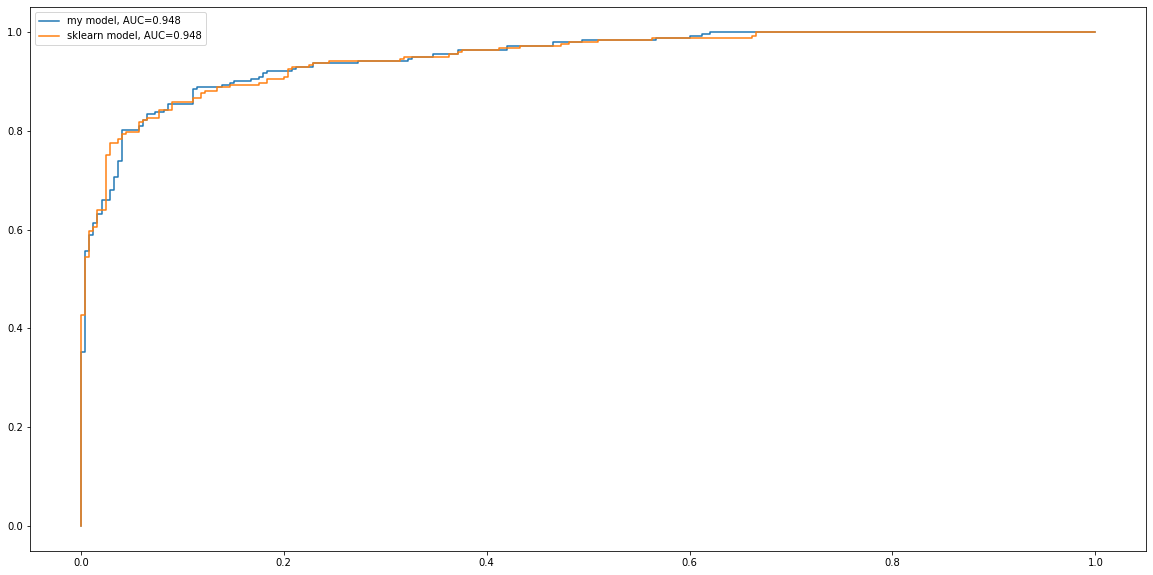

In [41]:
data_classification = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state))
data_classification.normalize()
compare_models(data_classification)

Implementacja wlasna 	uczyla sie przez 88288400 ns
Model sklearn 			 uczyl sie przez 2988300 ns


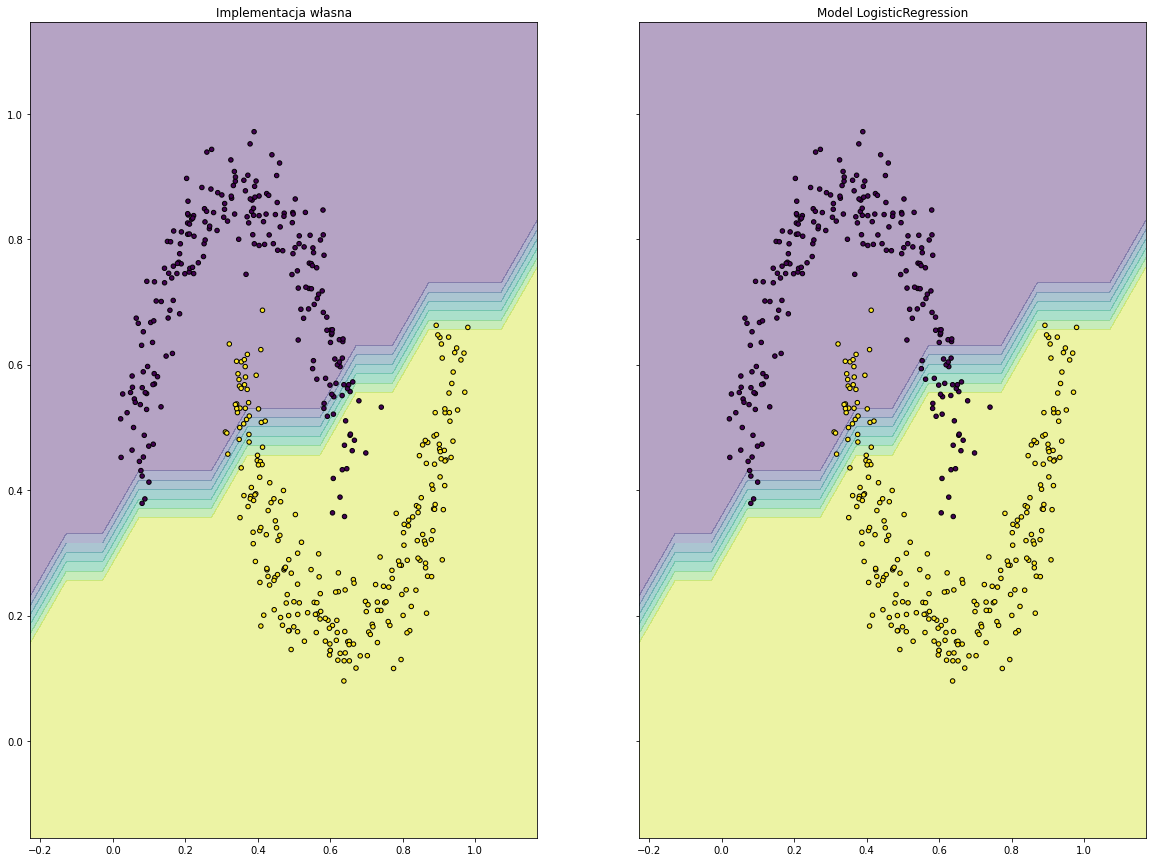

Implementacja wlasna 	wykonała predykcje w 0 ns
Model sklearn 			 wykonał predykcje w 0 ns


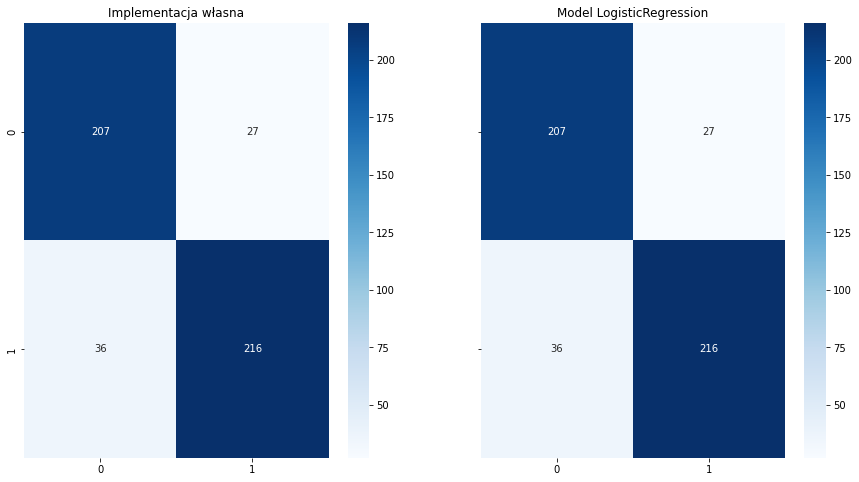

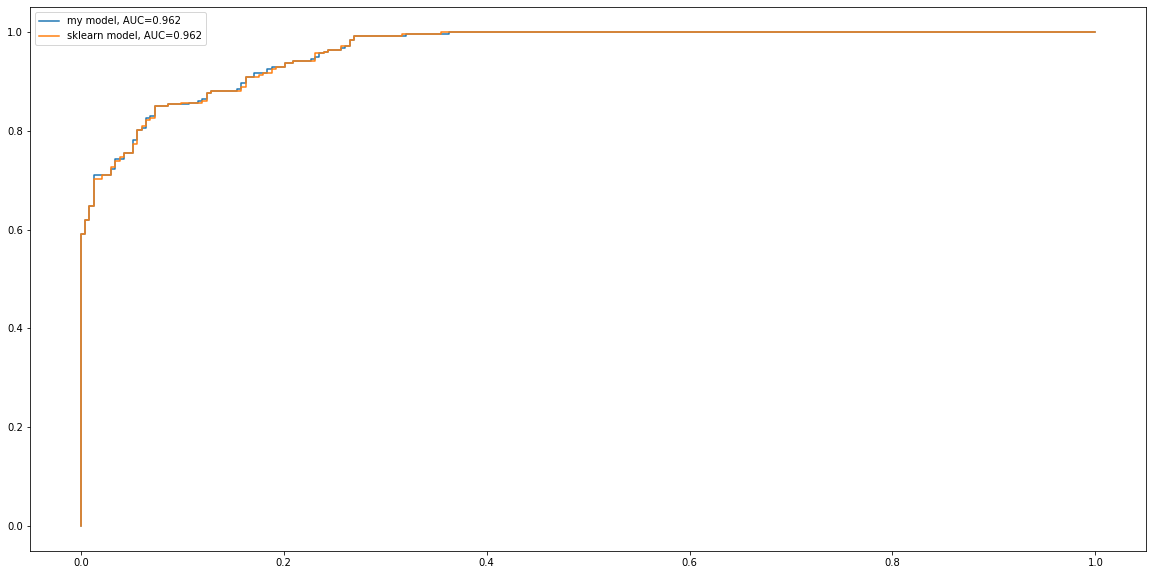

In [17]:
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.1, random_state=random_state))
data_moons.normalize()
compare_models(data_moons)

Implementacja włąsna uczyła się o cały rząd wielkości dłużej niż sklearn aby osiągnąć ten sam efekt.

In [65]:
# read data from rainAUS.csv to pandasa dataframe
rainDF = pd.read_csv('rainAUS.csv', delimiter=',')
rainDF = rainDF.loc[:, rainDF.isin(['NaN', np.NaN]).mean() < .3]

In [66]:
dirs_dict = {}
for i, name in enumerate(rainDF.WindGustDir.unique()):
    dirs_dict[name] = i

locations_dict = {}
for i, name in enumerate(rainDF.Location.unique()):
    locations_dict[name] = i

In [67]:
test = rainDF.copy()

In [68]:
test = test.replace({'WindGustDir': dirs_dict, 'WindDir3pm': dirs_dict, 'WindDir9am': dirs_dict})
test.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir        int64
WindGustSpeed    float64
WindDir9am         int64
WindDir3pm         int64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [63]:
test.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,0,13.4,22.9,0.6,0,44.0,0,1,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,2008-12-02,0,7.4,25.1,0.0,1,44.0,4,2,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,2008-12-03,0,12.9,25.7,0.0,2,46.0,0,2,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,2008-12-04,0,9.2,28.0,0.0,3,24.0,13,15,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,2008-12-05,0,17.5,32.3,1.0,0,41.0,9,12,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
